### Import Libraries

In [337]:
import pandas as pd 
import numpy as np
import os
import json
import xgboost as xgb
import lightgbm as lgb
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.layers import Dense, Conv2D, Embedding, Dropout, Conv1D, GlobalMaxPooling1D, LSTM, Bidirectional
# from keras.wrappers.scikit_learn import KerasClassifier
# from keras.preprocessing.sequence import pad_sequences
# from keras.preprocessing.text import Tokenizer
# from keras.models import Sequential, load_model
# from keras import layers, Input, Model
from sklearn import preprocessing
from sklearn.utils import resample, shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from classes.Accuracy import Accuracy
from classes.ModelBuilder import ModelBuilder
modelBuilder = ModelBuilder()

C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Select Classifier

In [338]:
# # Model constants.
# max_features = 20000
# embedding_dim = 128
# sequence_length = 500
# vocab_size = 30982
# max_length = 5890#len(tfidf_vect.get_feature_names())
# 
# # define baseline model
# def baseline_model():
#     # create model
#     model = Sequential()
#     model.add(Embedding(vocab_size, 128, trainable = False))
#     model.add(Bidirectional(LSTM(128)))
# #   model.add(LSTM(128))
#     model.add(Dense(32, activation = "relu"))
#     model.add(Dropout(0.5))
#     model.add(Dense(352, activation = "softmax"))
#     model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])    
#     return model

In [339]:
#classifier = xgb.XGBClassifier(n_jobs=-1, verbose=2)
#classifier = SVC(verbose=2,class_weight='balanced')
classifier = LinearSVC(verbose=2, random_state=42)
#classifier = RandomForestClassifier(n_jobs=-1, verbose=2)
#classifier = BalancedRandomForestClassifier(n_jobs=-1, verbose=2)
#classifier = KNeighborsClassifier(n_jobs=-1)
#classifier = lgb.LGBMClassifier()
#classifier = DecisionTreeClassifier()
#classifier = KerasClassifier(build_fn=baseline_model, batch_size=32)

In [340]:
# #--------------------------------------------------#
# ### TO USE STACKING OR VOTING UNCOMMENT ALL THIS ###
# #--------------------------------------------------#
# # define the base models
# level0 = list()	
# level0.append(('knc', KNeighborsClassifier()))
# level0.append(('lsvc', LinearSVC()))
# level0.append(('svm', SVC(C=10, gamma=0.1)))	
# # define meta learner model
# level1 = LogisticRegression()
# # define the stacking ensemble
# classifier = StackingClassifier(estimators=level0, final_estimator=level1, verbose=2)
# #classifier = VotingClassifier(estimators=level0, verbose=2)

### Helper Code

In [341]:
def add_mock_data(df, category, multiplier=10):    
    mask = (df['Intencion_cat_label'] == category)
    row = df[mask]
    return df.append([row]*multiplier,ignore_index=True)

def apply_resample(df, column, num_cases=5, multiplier=10):
    print('-----------------')
    print('Before Resample: ')
    print('-----------------')
    print('Train Shape: ' + str(df.shape))
    
    #add another row to minority class with few values
    grouped = df.groupby('Intencion_cat_label').count().sort_values(by='Intencion_cat_label', ascending=True)
    poor_cases = grouped[grouped[column] < num_cases]
    print('Poor cases: {}'.format(len(poor_cases)))
    print(poor_cases)
    for index in poor_cases.index.unique():
        df = add_mock_data(df, index, multiplier)

    print('----------------')
    print('After Resample: ')
    print('----------------')
    print('Train Shape: ' + str(df.shape))
    return df

### Get Info from CSV

In [342]:
columns = ['Pregunta', 'Intencion']
df_train = shuffle(pd.read_csv('data/train.csv', usecols=columns, sep='|'))
df_test = shuffle(pd.read_csv('data/test_santander.csv', usecols=['id','Pregunta']))

df_train['Intencion_cat_label'] = df_train['Intencion'].str[4:]
df_train['Intencion_cat_label'] = df_train['Intencion_cat_label'].astype('int32')

In [343]:
df_train['Intencion_cat_label'].value_counts()

132    600
293    567
1      493
147    488
223    477
      ... 
11       3
15       3
13       3
24       2
104      1
Name: Intencion_cat_label, Length: 352, dtype: int64

In [344]:
# add one more sample because I have one case with just one sample and stratify need at least 2 samples
df_train = apply_resample(df_train, 'Pregunta', 2, 1)

-----------------
Before Resample: 
-----------------
Train Shape: (20104, 3)
Poor cases: 1
                     Pregunta  Intencion
Intencion_cat_label                     
104                         1          1
----------------
After Resample: 
----------------
Train Shape: (20105, 3)


In [345]:
X = df_train['Pregunta'].values
y = df_train['Intencion_cat_label'].values

C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### train_test_split

In [346]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size = 0.20, stratify=y)
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [347]:
#Join X_train and y_train to add more classes to train

df_Xtrain = pd.DataFrame(X_train, columns=['Pregunta'])
df_Xtrain.set_index('Pregunta')
df_Xtrain['Intencion_cat_label'] = y_train
df_Xtrain.head(3)

C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Pregunta,Intencion_cat_label
0,quiero cambiar mis puntos por un premio y no l...,332
1,entrar devolucion promo freddo,312
2,quiero homologar todos los servicios e impuest...,132


C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


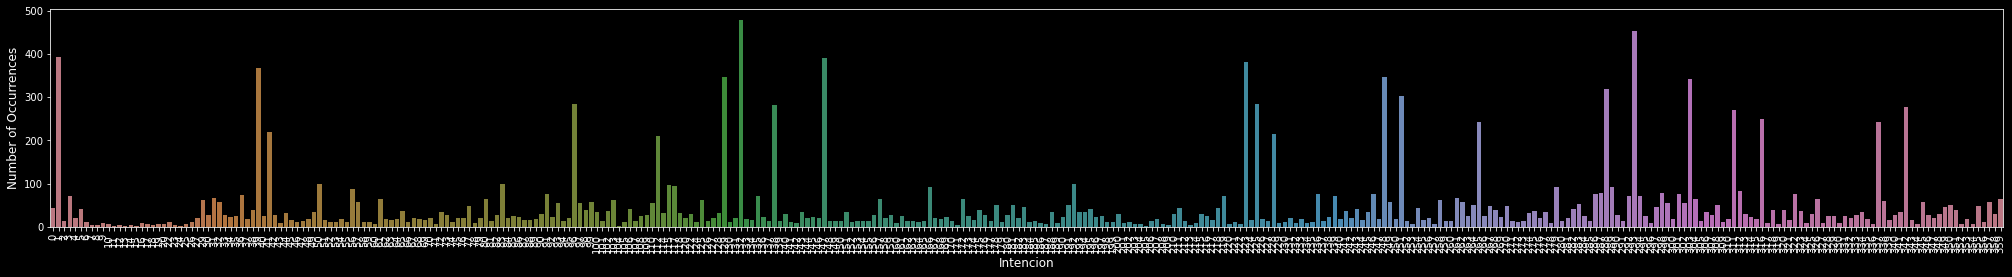

In [348]:
cnt_pro = df_Xtrain['Intencion_cat_label'].value_counts()

plt.figure(figsize=(35,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Intencion', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [349]:
#Apply resample to train dataset
df_Xtrain = apply_resample(df_Xtrain, 'Pregunta', 50, 100)

C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
-----------------
Before Resample: 
-----------------
Train Shape: (16084, 2)
Poor cases: 272
                     Pregunta
Intencion_cat_label          
0                          44
2                          12
4                          19
5                          42
6                          10
...                       ...
353                        18
354                         6
355                        47
356                        10
358                        30

[272 rows x 1 columns]
----------------
After Resample: 
----------------
Train Shape: (538084, 2)


In [350]:
X_train = df_Xtrain['Pregunta'].values
y_train = df_Xtrain['Intencion_cat_label'].values

C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [351]:
with mlflow.start_run():
    mlflow.log_param('Classifier', classifier.__class__.__name__)    
    resampling = True
    mlflow.log_param('resampling', resampling)
    vect_type='TfidfVectorizer'

    from imblearn.over_sampling import SMOTE, RandomOverSampler, SVMSMOTE, ADASYN
    from imblearn.under_sampling import RandomUnderSampler
    print('Preprocessing data...')
    vect = modelBuilder.GetVectorizer()
    sampling_strategy='minority'    
    k_neighbors = 5
    mlflow.log_param('sampling_strategy', sampling_strategy)
    mlflow.log_param('k_neighbors', k_neighbors)
    oversample = SMOTE(random_state=42, sampling_strategy=sampling_strategy, n_jobs=-1, k_neighbors=k_neighbors)
    print('Transforming data...')
    X_train = vect.fit_transform(X_train, y_train)
    print('Resampling data...')
    X_train, y_train = oversample.fit_resample(X_train, y_train)

    print(X_train.shape)
    print('Training Model...')
    classifier.fit(X_train, y_train)
    print('Predict on Test...')
    X_test = vect.transform(X_test)
    pred = classifier.predict(X_test)
    #Compute the balanced accuracy
    #The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class.
    #The best value is 1 and the worst value is 0 when adjusted=False.
    balanced_accuracy_score = Accuracy.get_balanced_accuracy_score(y_test, pred)
    accuracy_score = Accuracy.get_accuracy_score(y_test, pred)
    mlflow.log_metric("balanced_accuracy_score", balanced_accuracy_score)
    mlflow.log_metric("accuracy_score", accuracy_score)        
    mlflow.sklearn.log_model(classifier, "model")

    X = vect.fit_transform(X, y)
    print('Training Model With all train dataset...')
    classifier.fit(X, y)
    print('Finished Training Model With all train dataset.')
    training_score = classifier.score(X , y)
    print("Training score for all data: %f" % training_score)

Preprocessing data...
Transforming data...
Resampling data...
(542882, 5935)
Training Model...
[LibLinear]Predict on Test...

--------------------------------------------------------
-- Summary --
--------------------------------------------------------
balanced_accuracy_score: 0.7

--------------------------------------------------------
-- Summary --
--------------------------------------------------------
accuracy_score: 0.76
Training Model With all train dataset...
[LibLinear]Finished Training Model With all train dataset.
Training score for all data: 0.986023


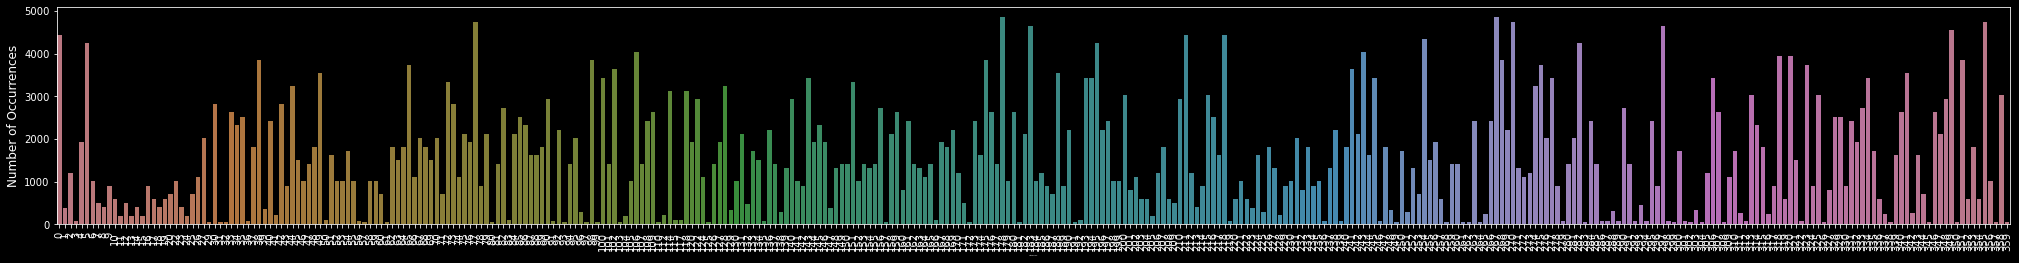

In [352]:
#mlflow.end_run()
df_Xtrain = pd.DataFrame(X_train, columns=['Pregunta'])
df_Xtrain.set_index('Pregunta')
df_Xtrain['Intencion_cat_label'] = y_train

cnt_pro = df_Xtrain['Intencion_cat_label'].value_counts()

plt.figure(figsize=(35,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Intencion', fontsize=2)
plt.xticks(rotation=90)
plt.show()

In [353]:
# with mlflow.start_run():
#     mlflow.log_param('Classifier', classifier.__class__.__name__)    
#     resampling = True
#     mlflow.log_param('resampling', resampling)
#     vect_type='TfidfVectorizer'
#     optimized_model, model_best_params, X_train, X_test, y_train, y_test = modelBuilder.GenerateTrainedModel(classifier, X_train, X_test, y_train, y_test, resampling=resampling, vect_type=vect_type)
# 
#     pred = optimized_model.predict(X_test)
#     #Compute the balanced accuracy
#     #The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class.
#     #The best value is 1 and the worst value is 0 when adjusted=False.
#     balanced_accuracy_score = Accuracy.get_balanced_accuracy_score(y_test, pred)
#     accuracy_score = Accuracy.get_accuracy_score(y_test, pred)
#     mlflow.log_metric("balanced_accuracy_score", balanced_accuracy_score)
#     mlflow.log_metric("accuracy_score", accuracy_score)    
#     for key, value in model_best_params.items():        
#         mlflow.log_param(key, value)
#     mlflow.sklearn.log_model(optimized_model, "model")

C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Train best model with all train data

In [354]:
#optimized_model = modelBuilder.TrainModel(X, y, classifier, vect_type=vect_type)

### Classification Report

In [355]:
report = Accuracy.get_classification_report(y_test, pred)
df_report = pd.DataFrame()
lines = report.split('\n')
for line in lines[2:-5]:    
    row_data = line.split('      ')             
    row = pd.Series(data={'class': row_data[1].strip(), 
                            'precision': row_data[2].strip(), 
                            'recall': row_data[3].strip(), 
                            'f1-score': row_data[4].strip(), 
                            'support': row_data[5].strip()
                            }
                            )
    df_report = df_report.append(row, ignore_index=True)
df_report['f1-score'] = df_report['f1-score'].astype(float)
df_report['precision'] = df_report['precision'].astype(float)
df_report['recall'] = df_report['recall'].astype(float)
df_report['class'] = df_report['class'].astype(int)


--------------------------------------------------------
-- Summary --
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.90      0.95      0.92        99
           2       1.00      0.33      0.50         3
           3       0.75      0.67      0.71        18
           4       1.00      0.80      0.89         5
           5       0.90      0.90      0.90        10
           6       1.00      1.00      1.00         3
           7       0.33      1.00      0.50         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         2
          10       0.67      1.00      0.80         2
          11       0.00      0.00      0.00         1
          12       1.00      1.00      1.00         1
          13       0.50      1.00      0.67         1
          14       0.00      0.00      0.00         1
      

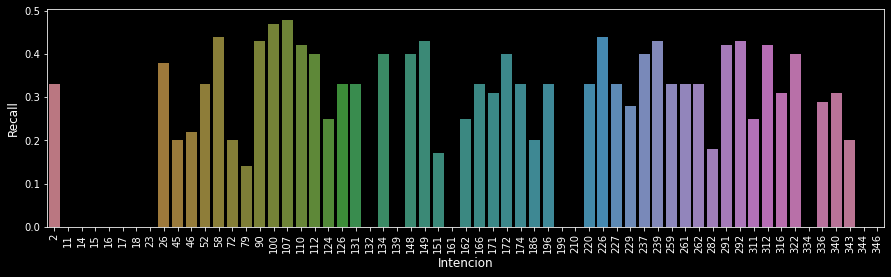

In [356]:
cnt_pro = df_report[df_report['recall'] < 0.50]

plt.figure(figsize=(15,4))
sns.barplot(cnt_pro.index, cnt_pro.recall, alpha=0.8)
plt.ylabel('Recall', fontsize=12)
plt.xlabel('Intencion', fontsize=12)
plt.xticks(rotation=90)
plt.show()

### Save predicted test to CSV

In [357]:
vect_data = vect.transform(df_test['Pregunta'].values)
pred_det = classifier.predict(vect_data)
df_test['Intencion'] = pred_det
SUBMIT_FILE = 'data/submit_{}.csv'.format(classifier.__class__.__name__)
df_test.to_csv(SUBMIT_FILE,mode='w', header=False, columns=['id','Intencion'], index=False, sep=',')

df_test.sample(3)

C:\ProgramData\Anaconda3\envs\env-fsadosky\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,Pregunta,Intencion
2900,2900,quiero ver el recibo de una operación,167
5634,5634,solicitud credito uva,223
3896,3896,consulto por prestamo personal. no soy cliente,248
